In [1]:
from pylab import *
%matplotlib inline

caffe_root = '../'  # this file should be run from {caffe_root}/examples (otherwise change this line)

import sys
sys.path.insert(0, caffe_root + 'python')
import caffe

In [29]:
def vis_square(data):
    """Take an array of shape (n, height, width) or (n, height, width, 3)
       and visualize each (height, width) thing in a grid of size approx. sqrt(n) by sqrt(n)"""
    
    # normalize data for display
    if data.max() >0 :
        data = (data - data.min()) / (data.max() - data.min())
    # force the number of filters to be square
    # show n*n grid
    n = int(np.ceil(np.sqrt(data.shape[0])))
    padding = (((0, n ** 2 - data.shape[0]),
               (0, 1), (0, 1))                 # add some space between filters
               + ((0, 0),) * (data.ndim - 3))  # don't pad the last dimension (if there is one)
    data = np.pad(data, padding, mode='constant', constant_values=1)  # pad with ones (white)
    
    # tile the filters into an image
    data = data.reshape((n, n) + data.shape[1:]).transpose((0, 2, 1, 3) + tuple(range(4, data.ndim + 1)))
    data = data.reshape((n * data.shape[1], n * data.shape[3]) + data.shape[4:])
    
    plt.imshow(data,cmap='gray'); plt.axis('off') #grayscale

# LeNet

In [21]:
caffe.set_mode_cpu()

### load the solver and create train and test nets
solver = None  # ignore this workaround for lmdb data (can't instantiate two solvers on the same data)
solver = caffe.SGDSolver('my_cnn_sample/lenet_auto_solver.prototxt')

In [22]:
!cat my_cnn_sample/lenet_auto_solver.prototxt

# The train/test net protocol buffer definition
train_net: "my_cnn_sample/lenet_auto_train.prototxt"
test_net: "my_cnn_sample/lenet_auto_test.prototxt"

# test_iter specifies how many forward passes the test should carry out.
# In the case of MNIST, we have test batch size 100 and 100 test iterations,
# covering the full 10,000 testing images.
test_iter: 100

# Carry out testing every 500 training iterations.
#test_interval: 500
test_interval: 100

# The base learning rate, momentum and the weight decay of the network.
base_lr: 0.01
momentum: 0.9
weight_decay: 0.0005

# The learning rate policy
lr_policy: "inv"
gamma: 0.0001
power: 0.75

# Display every 100 iterations
display: 100

# The maximum number of iterations
#max_iter: 10000
max_iter: 500

# snapshot intermediate results
snapshot: 500
snapshot_prefix: "my_cnn_sample/lenet"

# CPU/GPU
solver_mode: CPU


In [23]:
# each output is (batch size, feature dim, spatial dim)
[(k, v.data.shape) for k, v in solver.net.blobs.items()]

[('data', (8, 1, 28, 28)),
 ('label', (8,)),
 ('conv1', (8, 20, 24, 24)),
 ('pool1', (8, 20, 12, 12)),
 ('conv2', (8, 50, 8, 8)),
 ('pool2', (8, 50, 4, 4)),
 ('fc1', (8, 500)),
 ('score', (8, 10)),
 ('loss', ())]

In [24]:
# just print the weight sizes (we'll omit the biases)
[(k, v[0].data.shape) for k, v in solver.net.params.items()]

[('conv1', (20, 1, 5, 5)),
 ('conv2', (50, 20, 5, 5)),
 ('fc1', (500, 800)),
 ('score', (10, 500))]

In [25]:
solver.net.forward()  # train net
solver.test_nets[0].forward()  # test net (there can be more than one)

{'loss': array(2.3022687435150146, dtype=float32)}

train labels: [ 5.  0.  4.  1.  9.  2.  1.  3.]


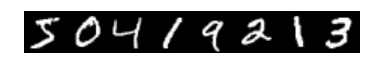

In [26]:
# show input data (training)
# we use a little trick to tile the first eight images
imshow(solver.net.blobs['data'].data[:8, 0].transpose(1, 0, 2).reshape(28, 8*28), cmap='gray'); axis('off')
print 'train labels:', solver.net.blobs['label'].data[:8]

test labels: [ 7.  2.  1.  0.  4.  1.  4.  9.]


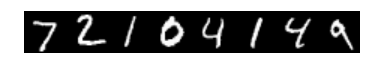

In [27]:
imshow(solver.test_nets[0].blobs['data'].data[:8, 0].transpose(1, 0, 2).reshape(28, 8*28), cmap='gray'); axis('off')
print 'test labels:', solver.test_nets[0].blobs['label'].data[:8]

(20, 5, 5)


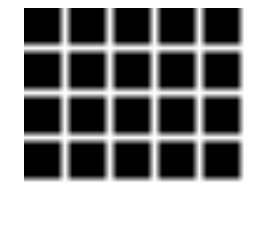

In [30]:
# Con1フィルターを表示。未学習だと真っ黒
# (20,1,5,5) -> (4,5,5,5)
filters = solver.net.params['conv1'][0].diff[:, 0]
print filters.shape
vis_square(filters)

In [31]:
# train 1step
solver.step(1)

(20, 5, 5)


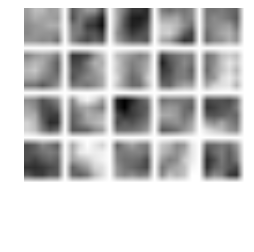

In [32]:
# Con1フィルターを表示

filters = solver.net.params['conv1'][0].diff[:, 0]
print filters.shape
vis_square(filters)

(50, 5, 5)


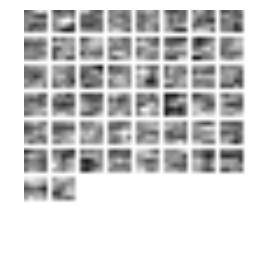

In [33]:
filters = solver.net.params['conv2'][0].diff[:, 0]
print filters.shape
vis_square(filters)

(8, 24, 24)


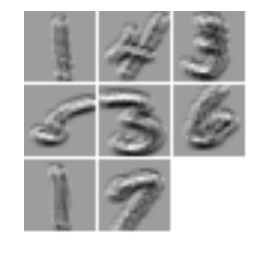

In [34]:
filters = solver.net.blobs['conv1'].data[:,0,:,:]
print filters.shape
vis_square(filters)

(8, 8, 8)


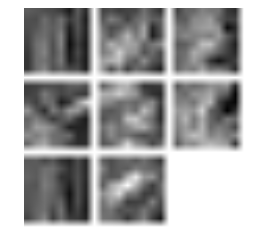

In [35]:
filters = solver.net.blobs['conv2'].data[:,0,:,:]
print filters.shape
vis_square(filters)

In [12]:
# train 500 iteration
!../build/tools/caffe train --solver=my_cnn_sample/lenet_auto_solver.prototxt

../build/tools/caffe: /home/suzuki/anaconda2/lib/liblzma.so.5: no version information available (required by /usr/lib/x86_64-linux-gnu/libunwind.so.8)
../build/tools/caffe: /home/suzuki/anaconda2/lib/liblzma.so.5: no version information available (required by /usr/lib/x86_64-linux-gnu/libavcodec-ffmpeg.so.56)
I0911 20:59:33.618990 13898 caffe.cpp:178] Use CPU.
I0911 20:59:33.619323 13898 solver.cpp:48] Initializing solver from parameters: 
train_net: "my_cnn_sample/lenet_auto_train.prototxt"
test_net: "my_cnn_sample/lenet_auto_test.prototxt"
test_iter: 100
test_interval: 100
base_lr: 0.01
display: 100
max_iter: 500
lr_policy: "inv"
gamma: 0.0001
power: 0.75
momentum: 0.9
weight_decay: 0.0005
snapshot: 500
snapshot_prefix: "my_cnn_sample/lenet"
solver_mode: CPU
I0911 20:59:33.619468 13898 solver.cpp:81] Creating training net from train_net file: my_cnn_sample/lenet_auto_train.prototxt
I0911 20:59:33.619763 13898 net.cpp:49] Initializing net from parameters: 
state {
  phase: TRAIN
}
lay

In [44]:
solver = None  # ignore this workaround for lmdb data (can't instantiate two solvers on the same data)
solver = caffe.SGDSolver('my_cnn_sample/lenet_auto_solver.prototxt')
solver.net.copy_from('my_cnn_sample/lenet_iter_500.caffemodel')
solver.test_nets[0].share_with(solver.net)

In [45]:
solver.net.forward()  # train net
solver.test_nets[0].forward()  # test net (there can be more than one)

{'loss': array(0.023400237783789635, dtype=float32)}

In [46]:
solver.step(1)

(20, 5, 5)


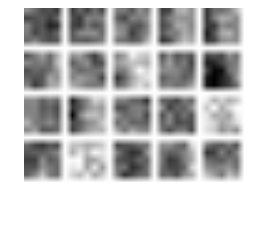

In [47]:
filters = solver.net.params['conv1'][0].diff[:, 0]
print filters.shape
vis_square(filters)

(50, 5, 5)


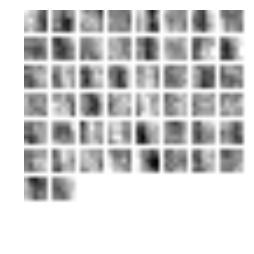

In [48]:
filters = solver.net.params['conv2'][0].diff[:, 0]
print filters.shape
vis_square(filters)

(8, 24, 24)


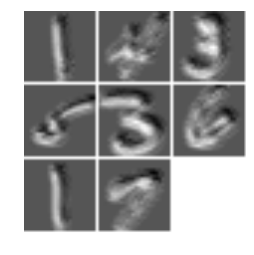

In [49]:
filters = solver.net.blobs['conv1'].data[:,0,:,:]
print filters.shape
vis_square(filters)

(8, 8, 8)


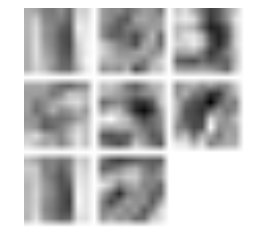

In [50]:
filters = solver.net.blobs['conv2'].data[:,0,:,:]
print filters.shape
vis_square(filters)

# Cifar10

In [ ]:
caffe.set_mode_cpu()

### load the solver and create train and test nets
solver_cifar = None  # ignore this workaround for lmdb data (can't instantiate two solvers on the same data)
solver_cifar = caffe.SGDSolver('my_cnn_sample/cifar10_solver.prototxt')

In [4]:
# each output is (batch size, feature dim, spatial dim)
[(k, v.data.shape) for k, v in solver_cifar.net.blobs.items()]

[('data', (64, 1, 28, 28)),
 ('label', (64,)),
 ('conv1', (64, 32, 28, 28)),
 ('pool1', (64, 32, 14, 14)),
 ('conv2', (64, 32, 14, 14)),
 ('pool2', (64, 32, 7, 7)),
 ('conv3', (64, 64, 7, 7)),
 ('pool3', (64, 64, 3, 3)),
 ('ip1', (64, 64)),
 ('ip2', (64, 10)),
 ('loss', ())]

In [5]:
# just print the weight sizes (we'll omit the biases)
[(k, v[0].data.shape) for k, v in solver_cifar.net.params.items()]

[('conv1', (32, 1, 5, 5)),
 ('conv2', (32, 32, 5, 5)),
 ('conv3', (64, 32, 5, 5)),
 ('ip1', (64, 576)),
 ('ip2', (10, 64))]

In [6]:
solver_cifar.net.forward()  # train net
solver_cifar.test_nets[0].forward()  # test net (there can be more than one)

{'accuracy': array(0.14000000059604645, dtype=float32),
 'loss': array(2.3025829792022705, dtype=float32)}

train labels: [ 5.  0.  4.  1.  9.  2.  1.  3.]
(8, 28, 28)
(28, 8, 28)
(28, 224)


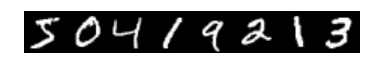

In [7]:
# show input data (training)
# we use a little trick to tile the first eight images
imshow(solver_cifar.net.blobs['data'].data[:8, 0].transpose(1, 0, 2).reshape(28, 8*28), cmap='gray'); axis('off')
print 'train labels:', solver_cifar.net.blobs['label'].data[:8]

# blobs['data'] is first layer, which is original data!
# インプットデータを並び替えて先頭８データを１枚の絵にして表示している
print (solver_cifar.net.blobs['data'].data[:8, 0].shape)
print (solver_cifar.net.blobs['data'].data[:8, 0].transpose(1, 0, 2).shape)
print (solver_cifar.net.blobs['data'].data[:8, 0].transpose(1, 0, 2).reshape(28, 8*28).shape)


test labels: [ 7.  2.  1.  0.  4.  1.  4.  9.]


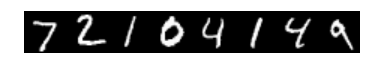

In [8]:
# show input data (test)
imshow(solver_cifar.test_nets[0].blobs['data'].data[:8, 0].transpose(1, 0, 2).reshape(28, 8*28), cmap='gray'); axis('off')
print 'test labels:', solver_cifar.test_nets[0].blobs['label'].data[:8]

In [10]:
# train 1step
solver_cifar.step(1)

(32, 5, 5)
(20, 40)


(-0.5, 39.5, 19.5, -0.5)

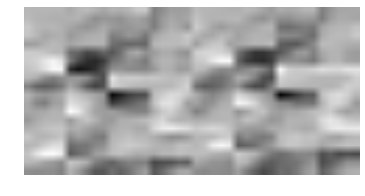

In [11]:
# Con1フィルターを表示。未学習だと真っ黒
# (32,1,5,5) -> (4,8,5,5)

print (solver_cifar.net.params['conv1'][0].diff[:, 0].shape)
#print (solver.net.params['conv1'][0].diff[:, 0].reshape(4,8,5,5)[:1,:1,:,:]) # 最初のfeature map
#imshow(solver.net.params['conv1'][0].diff[:, 0].reshape(4, 8, 5, 5)[:1,:1,:,:].reshape(5,5), cmap='gray'); axis('off')

# 32枚のfeature mapを 4*8グリッドで表示する
print (solver_cifar.net.params['conv1'][0].diff[:, 0].reshape(4,8,5,5).transpose(0,2,1,3).reshape(4*5,8*5).shape)
imshow(solver_cifar.net.params['conv1'][0].diff[:, 0].reshape(8, 4, 5, 5).transpose(0, 2, 1, 3).reshape(4*5, 8*5), cmap='gray'); axis('off')

In [15]:
!../build/tools/caffe train --solver=my_cnn_sample/cifar10_solver.prototxt

../build/tools/caffe: /home/suzuki/anaconda2/lib/liblzma.so.5: no version information available (required by /usr/lib/x86_64-linux-gnu/libunwind.so.8)
../build/tools/caffe: /home/suzuki/anaconda2/lib/liblzma.so.5: no version information available (required by /usr/lib/x86_64-linux-gnu/libavcodec-ffmpeg.so.56)
I0911 15:47:50.629876 12714 caffe.cpp:178] Use CPU.
I0911 15:47:50.630164 12714 solver.cpp:48] Initializing solver from parameters: 
train_net: "my_cnn_sample/cifar10_train.prototxt"
test_net: "my_cnn_sample/cifar10_test.prototxt"
test_iter: 100
test_interval: 100
base_lr: 0.01
display: 100
max_iter: 500
lr_policy: "inv"
gamma: 0.0001
power: 0.75
momentum: 0.9
weight_decay: 0.0005
snapshot: 500
snapshot_prefix: "my_cnn_sample/cifar10"
solver_mode: CPU
I0911 15:47:50.630295 12714 solver.cpp:81] Creating training net from train_net file: my_cnn_sample/cifar10_train.prototxt
I0911 15:47:50.630543 12714 net.cpp:313] The NetState phase (0) differed from the phase (1) specified by a rul

In [17]:
solver_cifar = None  # ignore this workaround for lmdb data (can't instantiate two solvers on the same data)
solver_cifar = caffe.SGDSolver('my_cnn_sample/cifar10_solver.prototxt')
solver_cifar.net.copy_from('my_cnn_sample/cifar10_iter_500.caffemodel')
solver_cifar.test_nets[0].share_with(solver_cifar.net)

In [19]:
solver_cifar.net.forward()  # train net
solver_cifar.test_nets[0].forward()  # test net (there can be more than one)

{'accuracy': array(0.14000000059604645, dtype=float32),
 'loss': array(2.2905325889587402, dtype=float32)}

In [24]:
solver_cifar.step(1)

(-0.5, 39.5, 19.5, -0.5)

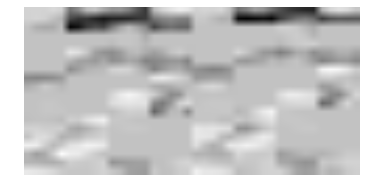

In [25]:
imshow(solver_cifar.net.params['conv1'][0].diff[:, 0].reshape(8, 4, 5, 5).transpose(0, 2, 1, 3).reshape(4*5, 8*5), cmap='gray'); axis('off')

(32, 1, 5, 5)
(32, 5, 5)


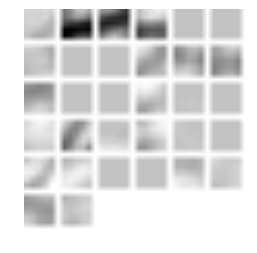

In [57]:
#filters = solver_cifar.net.params['conv1'][0].data
#print filters.shape
#vis_square(filters.transpose(0, 2, 3,1).reshape(32,5,5))

filters = solver_cifar.net.params['conv1'][0].diff[:, 0]
print filters.shape
vis_square(filters)
